<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/Laboratorio%205/MINE4210_ADL2024_Lab5_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Laboratorio 5 - Sesión 1**
## **VAE**

## **Tabla de Contenido**

[Contexto y objetivos.](#scrollTo=HVcY2LRFj86l&line=9&uniqifier=1)<br>
[0. Importación de librerías.](#scrollTo=55MTibTHkc0y&line=1&uniqifier=1)<br>
[1. Entendimiento y preparación de los datos.](#scrollTo=UDgQ-2HVkqQX&line=1&uniqifier=1)<br>
[2. Modelamiento y evaluación.](#scrollTo=Np7wYb-b5tsP&line=1&uniqifier=1)<br>

**Tutores**
- Fabián Camilo Castellanos.
- Nicolás Tibatá Castañeda.


## Contexto y objetivos

**Problema**
- En este problema queremos generar imagenes a través de un VAE.

**Objetivos**
- Entender la generación de Imágenes Aleatorias.
- Analizar la Arquitectura de los AutoEncoders Variacionales.
- Generar imágenes a partir de un VAE.

## 0. Importación de librerías

In [1]:
!pip install kaggle -q
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras


from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras import backend as K
from keras import applications
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.17.0


## 1. Entendimiento y preparación de los datos.

In [3]:
!ls -lha kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ruruamour/screw-dataset

ls: cannot access 'kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ruruamour/screw-dataset
License(s): CC-BY-NC-SA-4.0
 99% 185M/186M [00:09<00:00, 20.1MB/s]
100% 186M/186M [00:09<00:00, 20.3MB/s]


In [4]:
ROOT_DIR = '/content'
DATASET_NAME = 'screw-dataset'

%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  screw-dataset.zip
  inflating: /content/screw-dataset/license.txt  
  inflating: /content/screw-dataset/sample_submit.csv  
  inflating: /content/screw-dataset/test/test_0.png  
  inflating: /content/screw-dataset/test/test_1.png  
  inflating: /content/screw-dataset/test/test_10.png  
  inflating: /content/screw-dataset/test/test_100.png  
  inflating: /content/screw-dataset/test/test_101.png  
  inflating: /content/screw-dataset/test/test_102.png  
  inflating: /content/screw-dataset/test/test_103.png  
  inflating: /content/screw-dataset/test/test_104.png  
  inflating: /content/screw-dataset/test/test_105.png  
  inflating: /content/screw-dataset/test/test_106.png  
  inflating: /content/screw-dataset/test/test_107.png  
  inflating: /content/screw-dataset/test/test_108.png  
  inflating: /content/screw-dataset/test/test_109.png  
  inflating: /content/screw-dataset/test/test_11.png  
  inflating: /content/screw-dataset/test/test_110.png  
  inflating: /content/s

In [5]:
# Cargar el dataset de imágenes
image_size = (128, 128)  # Tamaño deseado para las imágenes
batch_size = 32
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}"

train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.2,
    subset="training",
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 300 files.
Using 240 files for training.
Found 180 files.
Using 36 files for validation.


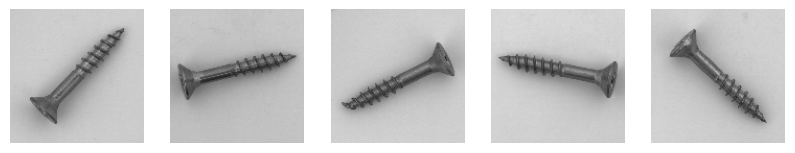

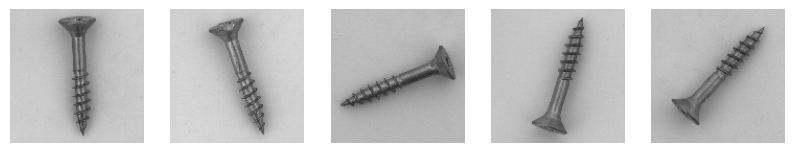

In [9]:
def display_sample_images(dataset, num_samples=5):
    # Tomar un batch de imágenes del dataset
    for images in dataset.take(1):  # Solo tomar un batch
        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()

# Mostrar algunas imágenes de train_ds
display_sample_images(train_ds)

# Mostrar algunas imágenes de val_ds
display_sample_images(test_ds)

In [8]:
# Normalizar las imágenes
train_ds = train_ds.map(lambda x: x / 255.0)
test_ds = test_ds.map(lambda x: x / 255.0)

# Preparar el dataset para entrenamiento y validación
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 2. Modelamiento y evaluación

In [37]:
from tensorflow.keras import layers, models

# Define el encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(128, 128, 3))  # Imagen de entrada
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name="VAE_Encoder")

# Define el decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense(32 * 32 * 64, activation='relu')(x)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name="VAE_Decoder")

# Definir el modelo VAE
latent_dim = 128  # Dimensión del espacio latente
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Función de muestreo para VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Definir el modelo VAE
z_mean, z_log_var = encoder.output
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
vae_output = decoder(z)

vae = models.Model(encoder.input, vae_output, name="VAE")

# Compilar el modelo
vae.compile(optimizer='adam', loss='mse')

In [38]:
encoder.summary()
decoder.summary()
vae.summary()

Model: "VAE_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 65536)          │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │      8,388,736 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         16,512 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         16,512 │ dense_12[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,441,152 (32.20 MB)

 Trainable params: 8,441,152 (32.20 MB)

 Non-trainable params: 0 (0.00 B)

Model: "VAE_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 65536)               │       8,454,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 64, 64, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 128, 128, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,526,915 (32.53 MB)

 Trainable params: 8,526,915 (32.53 MB)

 Non-trainable params: 0 (0.00 B)

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 32)     │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 65536)          │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │      8,388,736 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         16,512 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         16,512 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 128)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ VAE_Decoder (Functional)  │ (None, 128, 128, 3)    │      8,526,915 │ lambda_4[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,968,067 (64.73 MB)

 Trainable params: 16,968,067 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

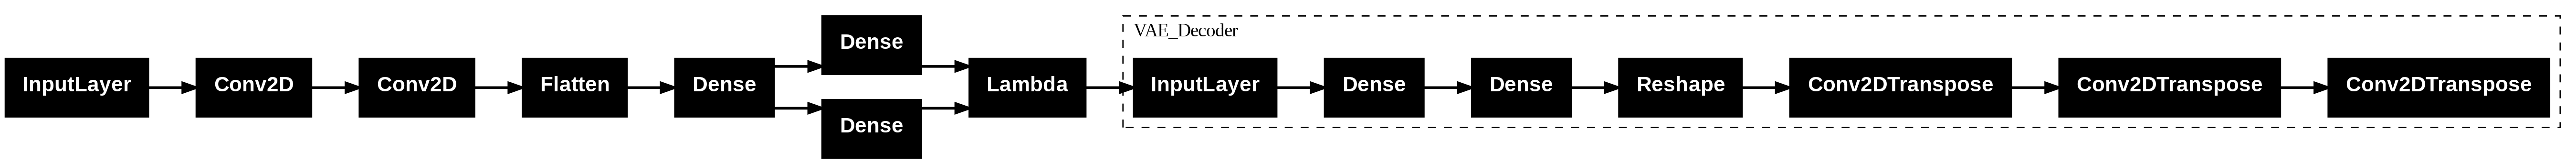

In [39]:
plot_model(vae, expand_nested=True, rankdir='LR')

In [40]:
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Pérdida de reconstrucción (Error cuadrático medio)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_decoded_mean), axis=[1, 2, 3]))

    # Pérdida de divergencia KL (entre la distribución de la representación latente y la normal estándar)
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

    # Pérdida total
    total_loss = reconstruction_loss + kl_loss
    return total_loss


In [41]:
import matplotlib.pyplot as plt

# Listas para almacenar las pérdidas por cada época
losses = []

epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Inicializar la pérdida para esta época
    epoch_loss = 0

    for images in train_ds:
        with tf.GradientTape() as tape:
            # Codificar las imágenes
            z_mean, z_log_var = encoder(images)
            z = sampling([z_mean, z_log_var])

            # Decodificar las representaciones latentes
            x_decoded_mean = decoder(z)

            # Calcular la pérdida
            loss = vae_loss(images, x_decoded_mean, z_mean, z_log_var)

        # Obtener los gradientes y actualizar los pesos
        grads = tape.gradient(loss, vae.trainable_variables)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        # Acumulamos la pérdida de esta iteración en la variable de la época
        epoch_loss += loss.numpy()

    # Promediar la pérdida de todas las iteraciones de la época
    epoch_loss /= len(train_ds)

    # Almacenar la pérdida de esta época
    losses.append(epoch_loss)

    # Imprimir la pérdida por época
    print(f"Loss: {epoch_loss}")


Epoch 1/100
Loss: 2583.8211669921875
Epoch 2/100
Loss: 998.1965103149414
Epoch 3/100
Loss: 738.3197326660156
Epoch 4/100
Loss: 686.9829788208008
Epoch 5/100
Loss: 672.5443649291992
Epoch 6/100
Loss: 662.4206848144531
Epoch 7/100
Loss: 662.9692916870117
Epoch 8/100
Loss: 654.3917694091797
Epoch 9/100
Loss: 650.0160827636719
Epoch 10/100
Loss: 652.5979995727539
Epoch 11/100
Loss: 651.0533294677734
Epoch 12/100
Loss: 646.1201553344727
Epoch 13/100
Loss: 649.3470230102539
Epoch 14/100
Loss: 651.0208587646484
Epoch 15/100
Loss: 652.8201904296875
Epoch 16/100
Loss: 644.4813766479492
Epoch 17/100
Loss: 643.5332717895508
Epoch 18/100
Loss: 648.3357391357422
Epoch 19/100
Loss: 628.4400863647461
Epoch 20/100
Loss: 597.3302154541016
Epoch 21/100
Loss: 548.0898132324219
Epoch 22/100
Loss: 506.15253829956055
Epoch 23/100
Loss: 493.34898376464844
Epoch 24/100
Loss: 477.73133087158203
Epoch 25/100
Loss: 422.4070472717285
Epoch 26/100
Loss: 382.1768035888672
Epoch 27/100
Loss: 361.79948806762695
Epoch

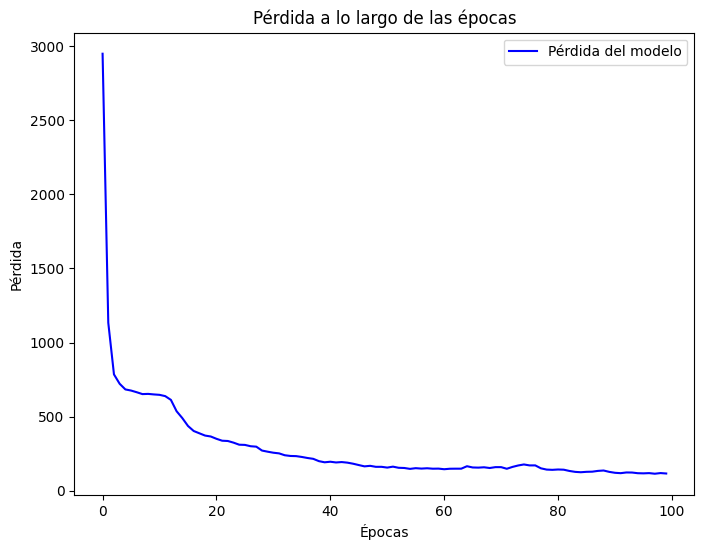

In [34]:
# Graficar la pérdida a lo largo de las épocas
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), losses, label='Pérdida del modelo', color='b')
plt.title('Pérdida a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


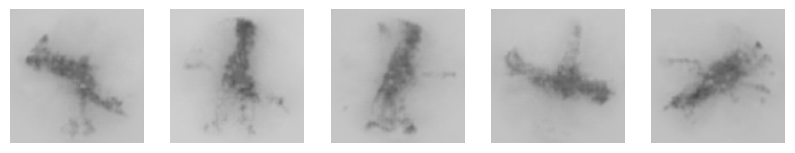

In [36]:
def generate_images(decoder, num_images=5, latent_dim=96):
    random_latents = np.random.normal(size=(num_images, latent_dim))  # Muestra de una normal estándar
    generated_images = decoder.predict(random_latents)

    # Mostrar las imágenes generadas
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Llamar a la función para generar imágenes
generate_images(decoder)